The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...
Data generated


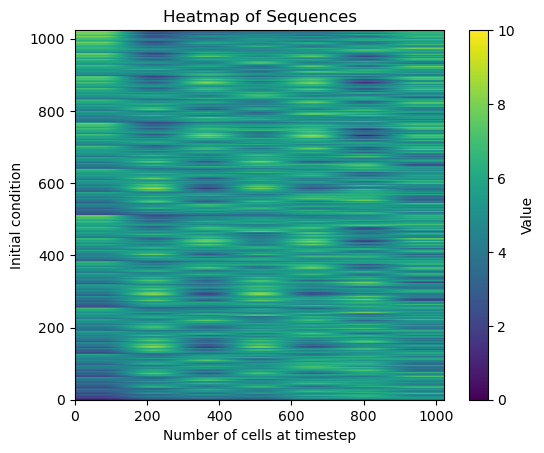

In [39]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
#Seedings and Config
class Wraparound1D(tf.keras.layers.Layer):
    """
    Apply periodic boundary conditions on a 1D sequence by padding 
    along the axis.
    padding : int or tuple, the amount to wrap around    
    """

    def __init__(self, padding=2, **kwargs):
        super(Wraparound1D, self).__init__()
        self.padding = padding
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'padding': self.padding,
        })
        return config
    def call(self, inputs):
        return periodic_padding(inputs, self.padding)
    
def periodic_padding(seq, padding=1):
    """
    Create a periodic padding (wrap) around a 1D sequence, to emulate 
    periodic boundary conditions.
    """
    seq_len = tf.shape(seq)[1]

    pad_left = seq[:, -padding:]
    pad_right = seq[:, :padding]

    padded_seq = tf.concat([pad_left, seq, pad_right], axis=1)

    return padded_seq
 
@tf.custom_gradient
def custom_binary_threshold(x):
    threshold = 1.0
    condition = tf.greater_equal(x, threshold)

    def grad(dy):
  
        grad_true = dy     
        grad_false = tf.zeros_like(dy)  

        return tf.where(condition, grad_true, grad_false)

    return tf.cast(condition, x.dtype), grad

 
 

def custom_bias_initializer(shape, dtype=None):
 
    initial_biases = tf.constant(0.1, shape=shape, dtype=dtype)
    return initial_biases
 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
# 2100 outer totalistic  Generating Data
samples=500
gridsize=10
#since 1d ca have fewer states, generate all possible initial conditions
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=3
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule_number(30)
#gol.set_rule([[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]],
 #                 [              [0],       [1],        [0],       [1],       [1],        [0],        [0],        [1]]])


sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 

collapsed_sequences=collapse_sequences(sequences)
#sequences=np.append(sequences,sequences,axis=0)
n = gridsize

#Some visualization of the dataset
plt.imshow(collapsed_sequences[::-1], cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences.shape[0], 0,
                  collapsed_sequences.shape[0]], vmin=0, vmax=n)
plt.colorbar(label='Value')
plt.xlabel("Number of cells at timestep")
plt.ylabel("Initial condition")
plt.title('Heatmap of Sequences')
plt.savefig("Heatmap_rule30")

#sequences=np.concatenate((sequences,sequences),axis=0)
np.random.shuffle(sequences)

x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
#might leave it unchanged for binary systems    
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
split_index = round(samples*0.85)
x_train = x_sequence
#x_train, x_val = x_sequence[:split_index] , x_sequence[split_index:]     
y_train= Y_val_onehot
#y_train, y_val = Y_val_onehot[:split_index], Y_val_onehot[split_index:]
#split_index=len(y_val)//2
#y_val, y_test = y_val[:split_index], y_val[split_index:]
#x_val, x_test = x_val[:split_index] , x_val[split_index:]   

 


loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                                             tf.reshape(y, shape=(-1, num_classes)),                                                             from_logits=True)


array([[[ 0],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]],

       [[ 1],
        [ 3],
        [ 3],
        ...,
        [ 4],
        [ 4],
        [ 6]],

       [[ 1],
        [ 3],
        [ 3],
        ...,
        [ 4],
        [ 4],
        [ 6]],

       ...,

       [[ 9],
        [ 1],
        [ 3],
        ...,
        [ 3],
        [ 3],
        [ 6]],

       [[ 9],
        [ 1],
        [ 3],
        ...,
        [ 3],
        [ 3],
        [ 6]],

       [[10],
        [ 0],
        [ 0],
        ...,
        [ 0],
        [ 0],
        [ 0]]])

In [10]:



num_filters = 1
kernel_size = MEMORY_CONSTANT

    
memory_horizon=MEMORY_CONSTANT 
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,MEMORY_CONSTANT  )))  
#model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                 #kernel_initializer=keras.initializers.ones(), 
                                  #       bias_initializer=custom_bias_initializer,trainable=True,use_bias=True,
                                 #activation="relu"
                                #  ))
model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
                               kernel_initializer=tf.keras.initializers.Ones()))
model.add(tf.keras.layers.Reshape((10,1)))
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(100, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
x_train_reshaped=tf.convert_to_tensor( np.array(x_train_reshaped).reshape(-1,10,MEMORY_CONSTANT ), dtype=tf.float32)
model.fit(x_train_reshaped, y_train, validation_data=(x_train_reshaped, y_train), epochs=100
        , batch_size=1,callbacks=[early_stopping_callback])
 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 10, 1)             12        
                                                                 
 reshape_5 (Reshape)         (None, 10, 1)             0         
                                                                 
 dense_5 (Dense)             (None, 10, 2)             4         
                                                                 
 wraparound1d_1 (Wraparound1  (None, 12, 2)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 10)            70        
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 100)           1100      
                                                      

In [53]:
output=model.predict(np.array(x_train_reshaped[0]).reshape(-1,10,MEMORY_CONSTANT,1))
binary_sequence = np.argmax(output, axis=-1)
 
binary_sequence = binary_sequence.reshape(10)
binary_sequence
 

1/1 [==============================] - 0s 154ms/step


array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [42]:
x_train[0]

array([[0, 1, 0, 1, 0, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0]])

In [35]:
model.weights

[<tf.Variable 'conv1d_43/kernel:0' shape=(10, 1, 1) dtype=float32, numpy=
 array([[[1.1832538]],
 
        [[1.3016875]],
 
        [[1.3061148]],
 
        [[1.2574362]],
 
        [[1.1440338]],
 
        [[1.1052065]],
 
        [[1.1465632]],
 
        [[1.2243618]],
 
        [[1.1883322]],
 
        [[2.391129 ]]], dtype=float32)>,
 <tf.Variable 'conv1d_43/bias:0' shape=(1,) dtype=float32, numpy=array([-0.80999494], dtype=float32)>,
 <tf.Variable 'dense_29/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.5759143, 1.4240763]], dtype=float32)>,
 <tf.Variable 'dense_29/bias:0' shape=(2,) dtype=float32, numpy=array([ 1.02245  , -1.3715444], dtype=float32)>,
 <tf.Variable 'conv1d_44/kernel:0' shape=(3, 2, 10) dtype=float32, numpy=
 array([[[-0.7341684 ,  0.14645135,  0.02083598,  0.11840642,
          -0.33157745,  0.8823122 ,  0.31299523, -0.180742  ,
          -1.4298292 , -0.33516645],
         [ 0.16269034, -0.25706157, -0.0511722 ,  0.10765892,
          -0.2892982 ,  0.1247

In [80]:
memory_horizon=MEMORY_CONSTANT=3 

#Part of the model that takes in (batch,10,3,1) and returns (batch,1,10,1)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,memory_horizon,1  )))  # Reshape input shape
model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
                                 kernel_initializer=custom_kernel_initializer, 
                                         bias_initializer=custom_bias_initializer,trainable=False
                                  ))
 
model.add(tf.keras.layers.Reshape((10,1)))
model.add(tf.keras.layers.Lambda(custom_binary_threshold))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])

#dummy array in shape (3,10)
dummy_array=np.array([[0,1,1,0,0,0,1,0,1,0],[1,0,1,1,1,0,1,0,0,1],[1,0,0,0,0,0,1,0,0,0]])
dummy_array=np.transpose(dummy_array)
dummy_array=dummy_array.reshape(1,10,3,1)
print(dummy_array.reshape(10,3))#stacked incorrectly as it 
 
 
model.predict(dummy_array)




[[0 1 1]
 [1 0 0]
 [1 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 0]
 [1 1 1]
 [0 0 0]
 [1 0 0]
 [0 1 0]]
1/1 [==============================] - 0s 77ms/step


array([[[1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [1]:
## r_model = tf.keras.Sequential()
r_model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon* gridsize)))

# Use LSTM layers instead of Conv1D layers
r_model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))
r_model.add(tf.keras.layers.LSTM(units=16, return_sequences=False))

# Reshape the output for further processing
#_model.add(tf.keras.layers.Reshape((memory_horizon, 64, 1)))

# Add more layers as needed
#r_model.add(tf.keras.layers.Dense(units=64, activation='relu'))
r_model.add(tf.keras.layers.Dense(units=20, activation='softmax'))

r_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
r_model.summary()

early_stopping_callback = CustomCallback()

# Assuming x_train has shape (batch_size, memory_horizon, gridsize)
r_model.fit(np.array(x_train).reshape(-1,3*10,1), y_train, validation_data=(tf.convert_to_tensor(x_train, dtype=tf.float32), y_train), epochs=1,
          batch_size=1, callbacks=[early_stopping_callback])

NameError: name 'r_model' is not defined

# Just The Memory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...
Data generated
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 10)                180       
                                                                 
 reshape_3 (Reshape)         (None, 10, 1)             0         
                                                                 
 dense_2 (Dense)             (None, 10, 2)             4         
                                                                 
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
4096/4096 [==============================] - 12s 3ms/step - loss: 0.6090 - accuracy: 0.6950 - val_loss: 0.5807 - val_accuracy: 0.7230
Epoch 2/2
4096/4096 [==============================] - 11s 3m

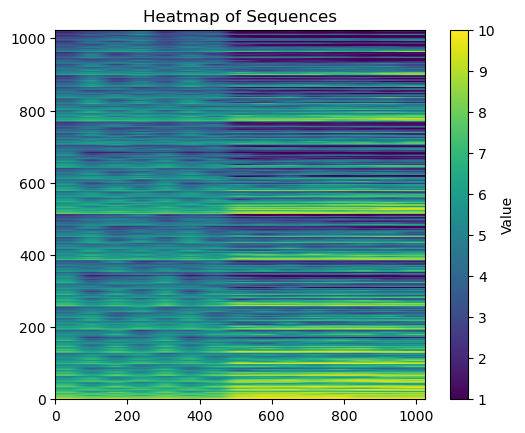

In [7]:

from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
 
 
 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
# 2100 outer totalistic  Generating Data
samples=500
gridsize=10
#since 1d ca have fewer states, generate all possible initial conditions
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=7
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
               [[0],      [1]         ,[0]      ,[1]     ,[1]      ,[0]      ,[0],     [1 ]]])
#gol.set_rule([[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]],
 #                 [              [0],       [1],        [0],       [1],       [1],        [0],        [0],        [1]]])


sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 

collapsed_sequences=collapse_sequences(sequences)
sequences=np.append(sequences,sequences,axis=0)
n = gridsize

#Some visualization of the dataset
plt.imshow(collapsed_sequences, cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences.shape[0], 0,
                   collapsed_sequences.shape[0]], vmin=1, vmax=n)
plt.colorbar(label='Value')
plt.title('Heatmap of Sequences')

sequences=np.concatenate((sequences,sequences),axis=0)
np.random.shuffle(sequences)
y_sequence= []
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
for x in x_sequence:
    y_sequence.append(gol.mostFrequentPastStateBinary(x))
y_sequence=np.array(y_sequence)

x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
#might leave it unchanged for binary systems    
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), 2))
split_index = round(samples*0.85)
x_train = x_sequence
     
y_train= Y_val_onehot


num_filters = 1
kernel_size = MEMORY_CONSTANT

    
memory_horizon=MEMORY_CONSTANT 
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(gridsize,memory_horizon   )))  

#model.add(tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size, padding='valid',
#                                 kernel_initializer=keras.initializers.ones(), 
 #                                        bias_initializer=custom_bias_initializer,trainable=True,use_bias=False,
  #                               activation="relu"
                                
   #                               ))

model.add(tf.keras.layers.SimpleRNN(units=1, return_sequences=True, activation='relu',
                               kernel_initializer=tf.keras.initializers.Ones()))
 
model.add(tf.keras.layers.Reshape((10,1)))
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))
                           

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()
x_train_reshaped=[]
for data_point in x_train:
    x_train_reshaped.append(np.transpose(data_point))
x_train_reshaped=np.array(x_train_reshaped)  
x_train_reshaped=tf.convert_to_tensor( np.array(x_train_reshaped).reshape(-1,10,MEMORY_CONSTANT ), dtype=tf.float32)
model.fit(x_train_reshaped, y_train, validation_data=(x_train_reshaped, y_train), epochs=2
        , batch_size=1,callbacks=[early_stopping_callback])
model.save("memory_only.h5")

In [57]:
model.predict(np.array(x_train_reshaped[1]).reshape(-1,10,MEMORY_CONSTANT,1))

1/1 [==============================] - 0s 88ms/step


array([[[1.8603135e-02, 9.8139679e-01],
        [2.5023252e-02, 9.7497672e-01],
        [2.6712804e-03, 9.9732870e-01],
        [2.2408004e-04, 9.9977589e-01],
        [2.1458799e-03, 9.9785411e-01],
        [1.7075086e-01, 8.2924908e-01],
        [1.5388855e-01, 8.4611148e-01],
        [9.5936608e-01, 4.0633913e-02],
        [6.8202716e-01, 3.1797284e-01],
        [9.3384260e-01, 6.6157386e-02]]], dtype=float32)

In [5]:
model.weights

[<tf.Variable 'simple_rnn_1/simple_rnn_cell_1/kernel:0' shape=(7, 1) dtype=float32, numpy=
 array([[1.7054176],
        [1.3982818],
        [1.5009807],
        [1.6137043],
        [1.6683371],
        [1.596241 ],
        [1.7512336]], dtype=float32)>,
 <tf.Variable 'simple_rnn_1/simple_rnn_cell_1/recurrent_kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.0179998]], dtype=float32)>,
 <tf.Variable 'simple_rnn_1/simple_rnn_cell_1/bias:0' shape=(1,) dtype=float32, numpy=array([-2.3864584], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[0.10070134, 1.8992993 ]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([ 3.2918503, -2.3429763], dtype=float32)>]